In [19]:
import cv2
import matplotlib.pyplot as plt
import yaml
import numpy as np
%matplotlib inline

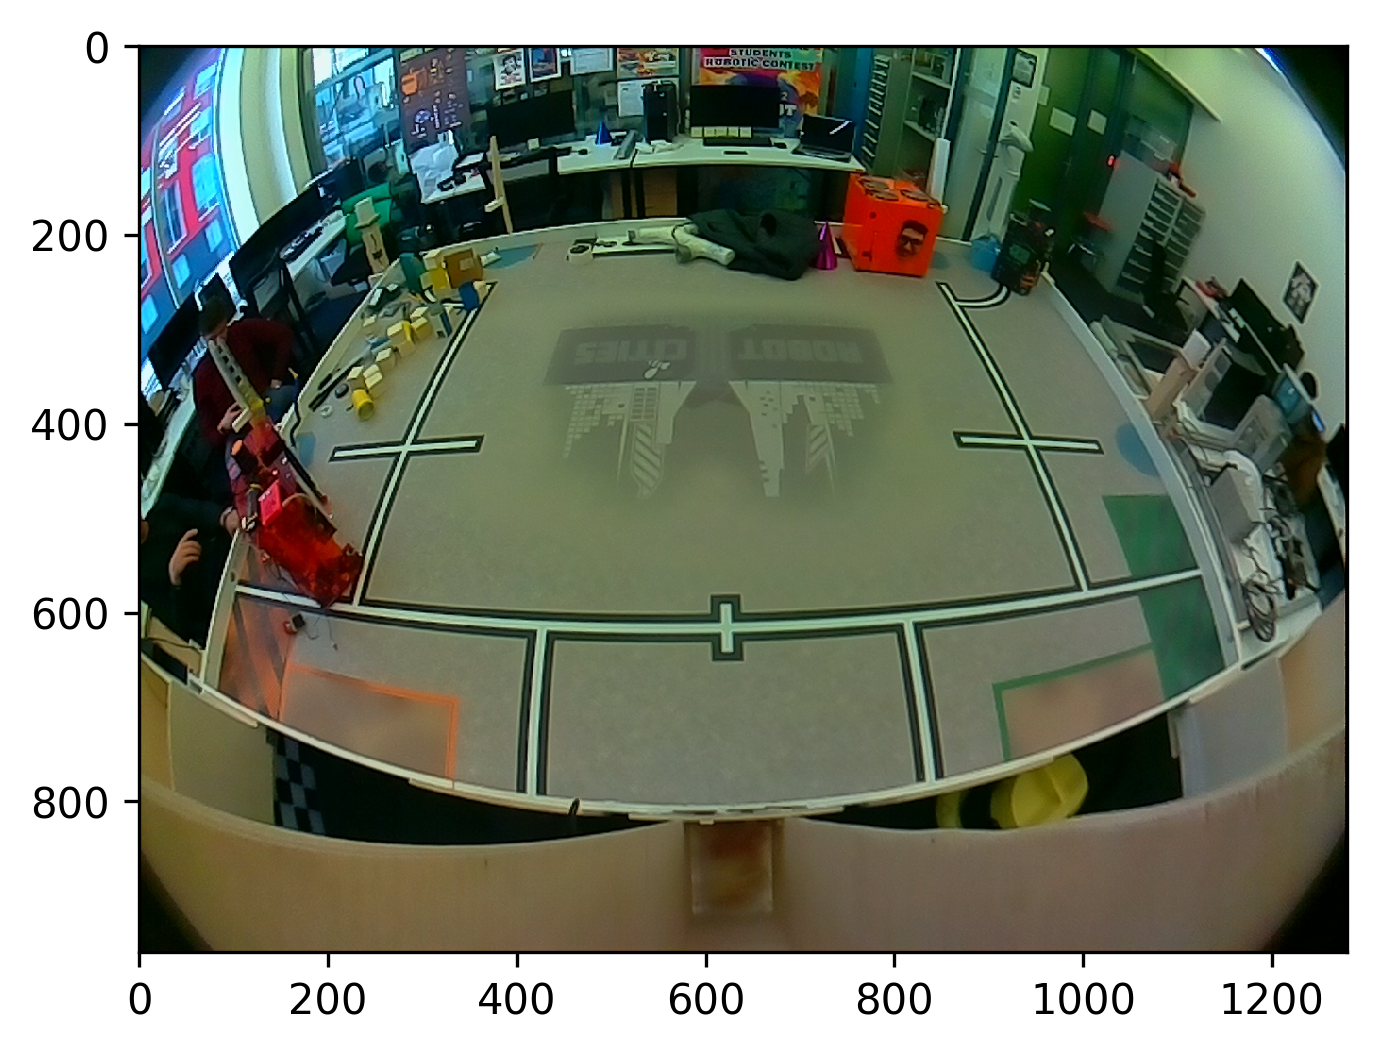

In [82]:
img = cv2.imread("imgs/field_img_2.png")
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

In [15]:
with open("camerav2_1280x960.yaml") as yfile:
    data = yaml.load(yfile)

In [136]:
A = camera_matrix = np.array(data["camera_matrix"]["data"]).reshape(data["camera_matrix"]["rows"], 
                                                             data["camera_matrix"]["cols"])
projection_matrix = np.array(data["projection_matrix"]["data"]).reshape(data["projection_matrix"]["rows"], 
                                                                        data["projection_matrix"]["cols"])
distortion_coefficients = np.array(data["distortion_coefficients"]["data"])

In [337]:
K_new = cv2.decomposeProjectionMatrix(projection_matrix)[0]
K_new

array([[381.10742187,   0.        , 655.13178354],
       [  0.        , 389.61557007, 512.27993728],
       [  0.        ,   0.        ,   1.        ]])

In [323]:
K_new = np.array([[550., -460, 0],
                   [0, -700, 300],
                   [0, -0.7, 0.7]])

In [313]:
K_new

array([[ 5.5e+02, -4.6e+02,  0.0e+00],
       [ 0.0e+00, -3.5e+02, -8.0e+02],
       [ 0.0e+00, -7.0e-01,  7.0e-01]])

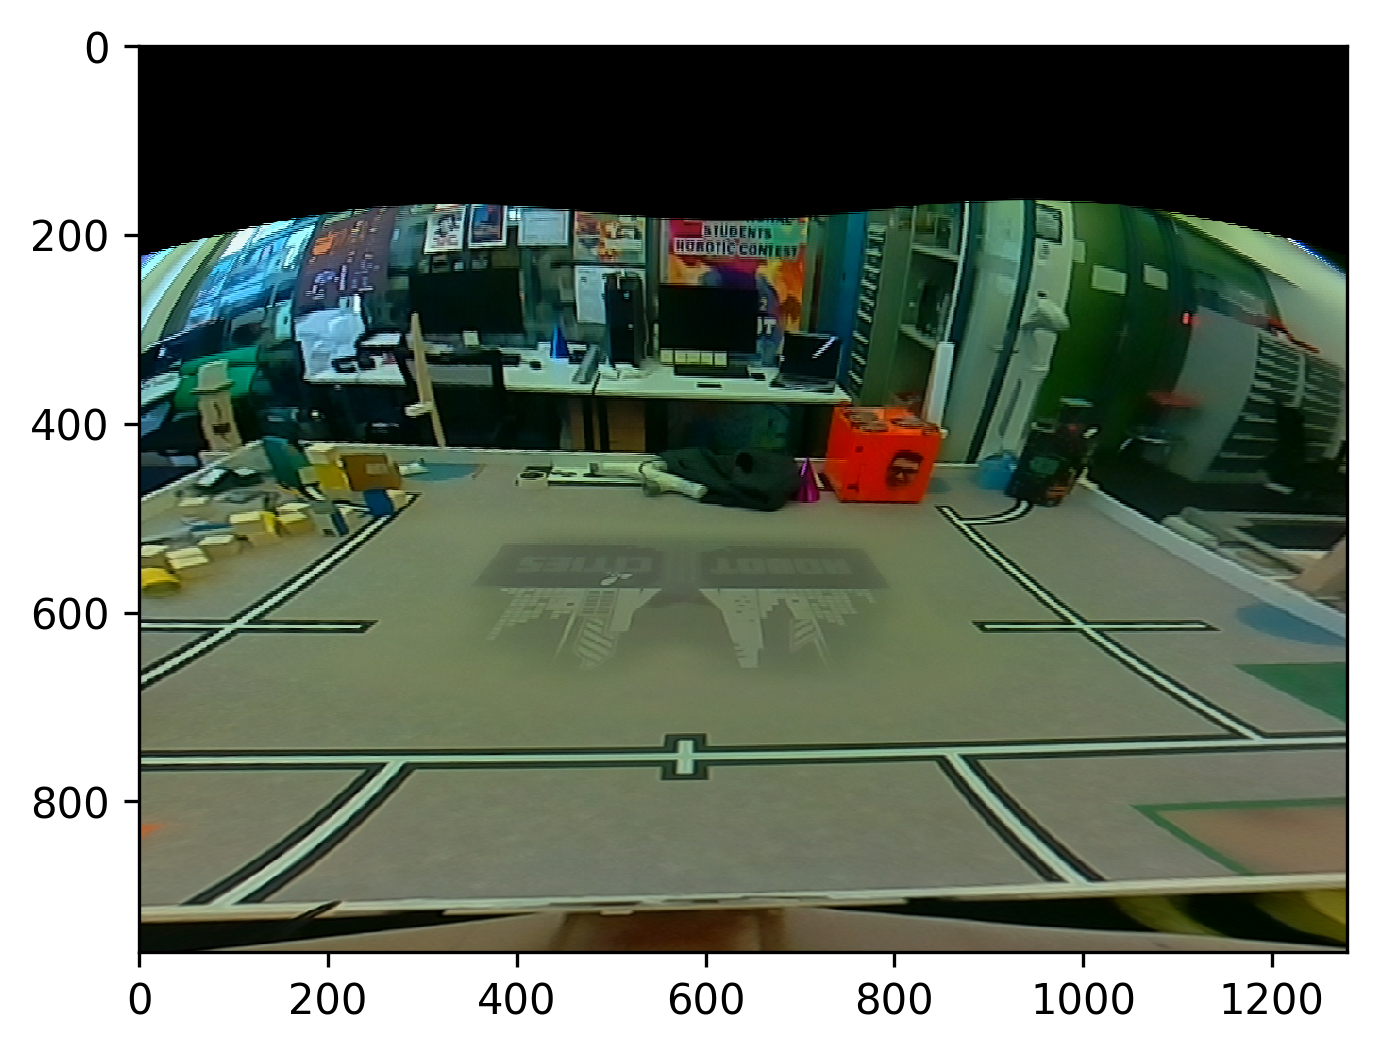

In [344]:
img1 = cv2.undistort(img, cam_matrix, distortion_coefficients, newCameraMatrix = K_new)
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_RGB2BGR))

In [70]:
data

{'camera_matrix': {'cols': 3,
  'data': [552.1270751787971,
   0,
   661.4107521874538,
   0,
   550.4242026921974,
   507.0790320495718,
   0,
   0,
   1],
  'rows': 3},
 'camera_name': 'camera',
 'distortion_coefficients': {'cols': 5,
  'data': [-0.2837290706525092,
   0.05685594416988724,
   -0.003467355713323754,
   -0.002211540919542785,
   0],
  'rows': 1},
 'distortion_model': 'plumb_bob',
 'image_height': 960,
 'image_width': 1280,
 'projection_matrix': {'cols': 4,
  'data': [381.107421875,
   0,
   655.1317835440859,
   0,
   0,
   389.6155700683594,
   512.2799372783993,
   0,
   0,
   0,
   1,
   0],
  'rows': 3},
 'rectification_matrix': {'cols': 3,
  'data': [1, 0, 0, 0, 1, 0, 0, 0, 1],
  'rows': 3}}

In [285]:
A

array([[552.12707518,   0.        , 661.41075219],
       [  0.        , 550.42420269, 507.07903205],
       [  0.        ,   0.        ,   1.        ]])

In [80]:
import cv2
assert cv2.__version__[0] == '3', 'The fisheye module requires opencv version >= 3.0.0'

import numpy as np
import os
import glob

CHECKERBOARD = (9, 4)

subpix_criteria = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 0.1)
calibration_flags = cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC+cv2.fisheye.CALIB_CHECK_COND+cv2.fisheye.CALIB_FIX_SKEW

objp = np.zeros((1, CHECKERBOARD[0]*CHECKERBOARD[1], 3), np.float32)
objp[0,:,:2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)

_img_shape = None
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

images = glob.glob('imgs/calibration/*.png')

for fname in images:
    img = cv2.imread(fname)
    if _img_shape == None:
        _img_shape = img.shape[:2]
    else:
        assert _img_shape == img.shape[:2], "All images must share the same size."

    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    print(gray)
    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD, None)
                                           #  , cv2.CALIB_CB_ADAPTIVE_THRESH+cv2.CALIB_CB_FAST_CHECK+cv2.CALIB_CB_NORMALIZE_IMAGE)
    # If found, add object points, image points (after refining them)
    print(ret)
    if ret == True:
        objpoints.append(objp)
        cv2.cornerSubPix(gray,corners,(3,3),(-1,-1),subpix_criteria)
        imgpoints.append(corners)

N_OK = len(objpoints)
K = np.zeros((3, 3))
D = np.zeros((4, 1))
rvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]
tvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]
rms, _, _, _, _ = \
    cv2.fisheye.calibrate(
        objpoints,
        imgpoints,
        gray.shape[::-1],
        K,
        D,
        rvecs,
        tvecs,
        calibration_flags,
        (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6)
    )
print("Found " + str(N_OK) + " valid images for calibration")
print("DIM=" + str(_img_shape[::-1]))
print("K=np.array(" + str(K.tolist()) + ")")
print("D=np.array(" + str(D.tolist()) + ")")

[[2 5 9 ... 1 1 1]
 [4 4 8 ... 1 1 1]
 [9 7 7 ... 1 1 1]
 ...
 [6 6 6 ... 2 2 2]
 [6 7 6 ... 3 2 3]
 [6 6 6 ... 3 2 2]]
False
[[ 9 10 12 ...  1  1  1]
 [11 12 11 ...  1  1  1]
 [11 11 16 ...  1  1  1]
 ...
 [ 4  2  9 ...  4  1  1]
 [ 4  7 13 ...  3  1  1]
 [ 9 12 13 ...  7  1  1]]
False
[[ 5  7 12 ...  1  1  1]
 [ 7  8 12 ...  1  1  1]
 [ 8  9 13 ...  1  1  1]
 ...
 [ 7  7  9 ...  2  1  1]
 [12 10 10 ...  3  1  1]
 [12 12 11 ...  2  1  1]]
False
[[12 12 14 ...  1  1  1]
 [11 12 12 ...  1  1  1]
 [ 8  9 11 ...  1  1  1]
 ...
 [ 8  9 11 ...  3  1  1]
 [13 11 11 ...  5  1  1]
 [15 14 12 ...  8  1  1]]
False
[[10  8  8 ...  1  1  1]
 [ 9  5 13 ...  1  1  1]
 [12 13 13 ...  1  1  1]
 ...
 [ 7  6  7 ...  3  1  1]
 [ 9  8  9 ...  3  1  1]
 [ 9  9 10 ...  5  1  1]]
False
[[ 6  6  9 ...  1  1  1]
 [ 6  6 10 ...  1  1  1]
 [ 8  8 12 ...  1  1  1]
 ...
 [ 5  5  8 ...  3  1  1]
 [ 6  9 10 ...  3  1  1]
 [11 10 11 ...  8  1  1]]
False
[[ 9 10 10 ...  1  1  1]
 [ 9 10 14 ...  1  1  1]
 [ 7  8 13 ...

KeyboardInterrupt: 

In [342]:
def eulerAnglesToRotationMatrix(theta):
    R_x = np.array([[1, 0, 0], [0, np.cos(theta[0]), -np.sin(theta[0])],
                    [0, np.sin(theta[0]),
                     np.cos(theta[0])]])
    R_y = np.array([[np.cos(theta[1]), 0,
                     np.sin(theta[1])], [0, 1, 0],
                    [-np.sin(theta[1]), 0,
                     np.cos(theta[1])]])
    R_z = np.array([[np.cos(theta[2]), -np.sin(theta[2]), 0],
                    [np.sin(theta[2]), np.cos(theta[2]), 0], [0, 0, 1]])
    R = np.dot(R_z, np.dot(R_y, R_x))
    return R

rotation_matrix = eulerAnglesToRotationMatrix((-np.pi / 4, 0, 0))
camera_position = np.array([[0, 1, -1]]).T
t = -rotation_matrix.dot(camera_position)
M = np.concatenate((rotation_matrix, t), axis=1)
M
A1 = np.array([[1000, 0, 635], [0, 1000, 480], [0, 0, 1]])

In [343]:
K_new = A1.dot(M).dot(np.array([[1, 0, 0], [0, 1, 0], [0, 0, 0], [0, 0, 1]]))

In [288]:
M.dot(np.array([[1, 0, 0], [0, 1, 0], [0, 0, 0], [0, 0, 1]]))

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -7.07106781e-01, -1.11022302e-16],
       [ 0.00000000e+00, -7.07106781e-01,  1.41421356e+00]])

In [289]:
K_new

array([[ 5.52127075e+02, -4.67688028e+02,  9.35376056e+02],
       [ 0.00000000e+00, -7.47767708e+02,  7.17118044e+02],
       [ 0.00000000e+00, -7.07106781e-01,  1.41421356e+00]])

In [142]:
M.dot(np.array([[1, 0, 0], [0, 1, 0], [0, 0, 0], [0, 0, 1]]))

array([[ 1.00000000e+00,  0.00000000e+00, -1.50000000e+03],
       [ 0.00000000e+00,  7.07106781e-01, -7.07106781e+02],
       [ 0.00000000e+00, -7.07106781e-01, -7.07106781e+02]])

In [257]:
L = np.array([[1, 0, 0],
              [0, 1 / np.sin(np.pi / 4), 0],
              [0, 0, 1]])

In [258]:
K_new = A.dot(L)

In [259]:
K_new

array([[552.12707518,   0.        , 661.41075219],
       [  0.        , 778.41737251, 507.07903205],
       [  0.        ,   0.        ,   1.        ]])